In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score

import os
import pandas as pd
import torchvision.transforms as transforms
import torchvision.models as models
import pickle
from statistics import mean

import torch.nn as nn 
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from torchvision.datasets import CelebA
from torch.utils.data import DataLoader, Dataset
from shared_interest.shared_interest import shared_interest
from shared_interest.util import flatten, binarize_std, normalize_0to1
from interpretability_methods.gradcam import GradCAM

In [3]:
class CelebADataset(CelebA):
    def __init__(self, root, split, image_transform = None, ground_truth_transform = None, ground_truth_type = "mouth"):
        super().__init__(root, split, ["attr", "landmarks"], transform=None, download = True)
        self.root = root
        self.image_transform = image_transform
        self.ground_truth_transform = ground_truth_transform
        self.ground_truth_type = ground_truth_type
        
    def __getitem__(self, idx):
        image, _ = super().__getitem__(idx)
        # 8 = black hair, 9 = blond hair, 31 = smiling
        attributes = self.attr[idx].numpy()
        black_hair = attributes[8]
        blond_hair = attributes[9]
        smiling = attributes[31]
        ground_truth = torch.tensor([])
        
        # if training, don't compute the ground truth
        if self.split == 'test':
            ground_truth = self._create_ground_truth_mouth(image, idx)
            
            # if ground truth was computed and transform exists:
            if ground_truth.numel() and self.ground_truth_transform is not None:
                ground_truth = self.ground_truth_transform(ground_truth).squeeze(0)
            
        if self.image_transform is not None:
            image = self.image_transform(image)
            
        return image, ground_truth, black_hair, blond_hair, smiling

    def _create_ground_truth_mouth(self, image, idx):
        """getting image segement of hair from CelebA annotations"""
        to_tensor = transforms.Compose([transforms.ToTensor(),])
        image_shape = to_tensor(image).shape
        height, width = int(image_shape[1]), int(image_shape[2])
        ground_truth = torch.zeros((height, width))
        
        # list of landmarks (last 4 are mouth coordinates)
        landmarks = self.landmarks_align[idx].numpy()
        
        left_x, left_y = int(landmarks[6]), int(landmarks[7])
        right_x, right_y = int(landmarks[8]), int(landmarks[9])
        height = round(((2/3) * (right_x - left_x))/2)
        left_y -= height
        right_y += height
        ground_truth[left_y:right_y, left_x:right_x] = 1
        
        return ground_truth

In [4]:
# general transforms
image_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224), transforms.ToTensor()])
ground_truth_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(256, Image.NEAREST),
                                             transforms.CenterCrop(224), transforms.ToTensor()])
reverse_image_transform = transforms.Compose([transforms.ToPILImage(),])

In [5]:
data_dir = ''
train_dataset = CelebADataset(data_dir, 'train', image_transform = image_transform, ground_truth_transform = ground_truth_transform)
test_dataset = CelebADataset(data_dir, 'test', image_transform = image_transform, ground_truth_transform = ground_truth_transform)

Files already downloaded and verified
Files already downloaded and verified


  0%|                                                                                                                   | 0/19962 [00:00<?, ?it/s]


torch.Size([1, 224, 224])


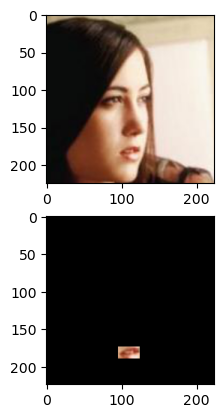

In [8]:
hair_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
fig, ax = plt.subplots(2)
for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(hair_loader)):
    print (ground_truth.shape)
    masked_image_hair = image[0] * ground_truth[0]
    ax[0].imshow(image[0].permute(1,2,0))
    ax[1].imshow(reverse_image_transform(masked_image_hair))
    break

In [ ]:
# getting index of images of each group from training dataset

black_smiling = []
black_not_smiling = []
blond_smiling = []
blond_not_smiling = []

for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(train_dataset)):
    if len(ground_truth) > 0:
        if black_hair and smiling:
            black_smiling.append(idx)
        elif black_hair and not smiling:
            black_not_smiling.append(idx)
        elif blond_hair and smiling:
            blond_smiling.append(idx)
        elif blond_hair and not smiling:
            blond_not_smiling.append(idx)
        
print (len(black_smiling))
print (len(black_not_smiling))
print (len(blond_smiling))
print (len(blond_not_smiling))

In [ ]:
# getting index of images of each group from test dataset

test_black_smiling = []
test_black_not_smiling = []
test_blond_smiling = []
test_blond_not_smiling = []

for idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_dataset)):
    if len(ground_truth) > 0:
        if black_hair and smiling:
            test_black_smiling.append(idx)
        elif black_hair and not smiling:
            test_black_not_smiling.append(idx)
        elif blond_hair and smiling:
            test_blond_smiling.append(idx)
        elif blond_hair and not smiling:
            test_blond_not_smiling.append(idx)
        
print (len(test_black_smiling))
print (len(test_black_not_smiling))
print (len(test_blond_smiling))
print (len(test_blond_not_smiling))

In [ ]:
"""getting biased and unbiased train/test groups"""

# biased train dataset 
biased_train_black_smiling = random.sample(black_smiling, 10000)
biased_train_blond_not_smiling = random.sample(blond_not_smiling, 10000)

biased_train_black_not_smiling = random.sample(black_not_smiling, 100)
biased_train_blond_smiling = random.sample(blond_smiling, 100)
biased_train_samples = biased_train_black_smiling + biased_train_black_not_smiling + biased_train_blond_smiling + biased_train_blond_not_smiling
len(biased_train_samples)

20200

In [ ]:
# unbiased train dataset
# get these from biased_samples (black smiling and blond not smiling) 
unbiased_train_black_smiling = random.sample(biased_train_black_smiling, 5000)
unbiased_train_blond_not_smiling = random.sample(biased_train_blond_not_smiling, 5000)

unbiased_train_black_not_smiling = biased_train_black_not_smiling + random.sample([k for k in black_not_smiling if k not in biased_train_black_not_smiling], 4900)
unbiased_train_blond_smiling = biased_train_blond_smiling + random.sample([k for k in blond_smiling if k not in biased_train_blond_smiling], 4900)
unbiased_train_samples = unbiased_train_black_smiling + unbiased_train_blond_not_smiling + unbiased_train_black_not_smiling + unbiased_train_blond_smiling
len(unbiased_train_samples)

20000

In [ ]:
# biased test dataset
biased_test_black_smiling = random.sample(test_black_smiling, 1000)
biased_test_blond_not_smiling = random.sample(test_blond_not_smiling, 1000)

biased_test_black_not_smiling = random.sample(test_black_not_smiling, 100)
biased_test_blond_smiling = random.sample(test_blond_smiling, 100)
biased_test_samples = biased_test_black_smiling + biased_test_blond_not_smiling + biased_test_black_not_smiling + biased_test_blond_smiling
len(biased_test_samples)

2200

In [15]:
# unbiased test dataset
# get these from biased_samples (black smiling and blond not smiling) 
unbiased_test_black_smiling = random.sample(biased_test_black_smiling, 500)
unbiased_test_blond_not_smiling = random.sample(biased_test_blond_not_smiling, 500)

unbiased_test_black_not_smiling = biased_test_black_not_smiling + random.sample([k for k in test_black_not_smiling if k not in biased_test_black_not_smiling], 400)
unbiased_test_blond_smiling = biased_test_blond_smiling + random.sample([k for k in test_blond_smiling if k not in biased_test_blond_smiling], 400)
unbiased_test_samples = unbiased_test_black_smiling + unbiased_test_blond_not_smiling + unbiased_test_black_not_smiling + unbiased_test_blond_smiling
len(unbiased_test_samples)

2000

In [17]:
biased_train = torch.utils.data.Subset(train_dataset, biased_train_samples)
unbiased_train = torch.utils.data.Subset(train_dataset, unbiased_train_samples)

In [18]:
biased_test = torch.utils.data.Subset(test_dataset, biased_test_samples)
unbiased_test = torch.utils.data.Subset(test_dataset, unbiased_test_samples)

In [19]:
biased_train_loader = torch.utils.data.DataLoader(biased_train, batch_size=128, shuffle=True)
unbiased_train_loader = torch.utils.data.DataLoader(unbiased_train, batch_size=128, shuffle=True)

In [18]:
biased_test_loader = torch.utils.data.DataLoader(biased_test, batch_size=128, shuffle=True)
unbiased_test_loader = torch.utils.data.DataLoader(unbiased_test, batch_size=128, shuffle=True)

In [30]:
def binarize_threshold(batch, threshold):
    batch_normalized = normalize_0to1(batch)
    binary_mask = (batch_normalized >= threshold).astype('uint8')
    return binary_mask

In [8]:
def train(epoch, device, model, optimizer, train_loader):
    model.train()
    
    criterion = nn.CrossEntropyLoss()
    loss_tot, correct, train_loss = 0, 0, 0
    for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(train_loader)):
        image = image.to(device)
        label = smiling.to(device)
        
        output = model(image)
        pred = torch.max(output, dim=-1)[1]
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        correct += (pred==label).sum().item()

    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print(f"Train Epoch: {epoch:0.01f} --- Loss: {train_loss:.05f}, Acc: {accuracy:.05f}")

In [ ]:
# if loading saved model 

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# biased_model_path = ''
# unbiased_model_path = ''

# biased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
# biased_model.load_state_dict(torch.load(biased_model_path))

# unbiased_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
# unbiased_model.load_state_dict(torch.load(unbiased_model_path))

In [9]:
def test(seed, model, device, test_loader):
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction="sum")
    saliency_method = GradCAM(model, model.layer4[2])
    test_loss = 0
    correct = 0
    total_shared_interest_scores = {'iou_coverage': np.array([]),
                                    'ground_truth_coverage': np.array([]),
                                    'saliency_coverage': np.array([]),}
    total_saliency_masks = np.array([[[]]])

    for batch_idx, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(tqdm(test_loader)):
        with torch.no_grad():
            image = image.to(device)
            ground_truth = ground_truth.numpy()
            label = smiling.to(device)

            output = model(image)
            pred = torch.max(output, dim=-1)[1]
            test_loss += criterion(output, label).item()
            correct += (pred==label).sum().item()
            
        saliency = flatten(saliency_method.get_saliency(image))
        saliency_masks = binarize_threshold(saliency, 0.5)

        if batch_idx == 0: 
            total_saliency_masks = saliency_masks
        else:
            total_saliency_masks = np.concatenate((total_saliency_masks, saliency_masks))
            
        # Compute Shared Interest scores
        for score in total_shared_interest_scores:
            shared_interest_scores = shared_interest(ground_truth, saliency_masks, score=score)
            total_shared_interest_scores[score] = np.concatenate((total_shared_interest_scores[score], shared_interest_scores))
                
        # Compute Pointing Game
        for i in range(saliency.shape[0]):
            saliency_batch = saliency[i]
            ground_truth_batch = ground_truth[i]
            pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
            point = ground_truth_batch[pixel[0], pixel[1]]

            # check if most salient feature is in ground truth 
            if point > 0:
                salient_pixel_count += 1
    pointing_game = salient_pixel_count / len(data_loader.dataset)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(test_type + ' test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    print('IoU coverage: ' + str(mean(total_shared_interest_scores['iou_coverage'])))
    print('Pointing Game: ' + str(pointing_game))

In [24]:
test_black_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_black_smiling)
test_black_not_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_black_not_smiling)
test_blond_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_blond_smiling)
test_blond_not_smiling_dataset = torch.utils.data.Subset(test_dataset, biased_test_blond_not_smiling)

test_black_smiling_loader = torch.utils.data.DataLoader(test_black_smiling_dataset, batch_size=64, shuffle=True)
test_black_not_smiling_loader = torch.utils.data.DataLoader(test_black_not_smiling_dataset, batch_size=64, shuffle=True)
test_blond_smiling_loader = torch.utils.data.DataLoader(test_blond_smiling_dataset, batch_size=64, shuffle=True)
test_blond_not_smiling_loader = torch.utils.data.DataLoader(test_blond_not_smiling_dataset, batch_size=64, shuffle=True)

test(seed, unbiased_model, device, test_black_smiling_loader)
test(seed, unbiased_model, device, test_black_not_smiling_loader)
test(seed, unbiased_model, device, test_blond_smiling_loader)
test(seed, unbiased_model, device, test_blond_not_smiling_loader)

test(seed, biased_model, device, test_black_smiling_loader)
test(seed, biased_model, device, test_black_not_smiling_loader)
test(seed, biased_model, device, test_blond_smiling_loader)
test(seed, biased_model, device, test_blond_not_smiling_loader)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:11<00:00,  1.35it/s]


biased_black_smiling test set: Average loss: 0.4655, Accuracy: 907/1000 (91%)
IoU coverage: 0.3686079464301107
Saliency Mean: 0.1085, Std: 0.1934


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


biased_black_not_smiling test set: Average loss: 0.1747, Accuracy: 96/100 (96%)
IoU coverage: 0.08247296353791514
Saliency Mean: 0.1178, Std: 0.2159


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.76it/s]


biased_blond_smiling test set: Average loss: 0.3350, Accuracy: 95/100 (95%)
IoU coverage: 0.3975263449122558
Saliency Mean: 0.1070, Std: 0.1910


100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.64it/s]


biased_blond_not_smiling test set: Average loss: 0.3211, Accuracy: 921/1000 (92%)
IoU coverage: 0.10409512946906106
Saliency Mean: 0.1172, Std: 0.2141


100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]


biased_black_smiling test set: Average loss: 0.0057, Accuracy: 996/1000 (100%)
IoU coverage: 0.0013012260352566118
Saliency Mean: 0.1272, Std: 0.2206


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.99it/s]


biased_black_not_smiling test set: Average loss: 4.1835, Accuracy: 10/100 (10%)
IoU coverage: 0.00029035601353354616
Saliency Mean: 0.1010, Std: 0.1985


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.06it/s]


biased_blond_smiling test set: Average loss: 1.9129, Accuracy: 62/100 (62%)
IoU coverage: 0.019857197565685335
Saliency Mean: 0.1144, Std: 0.2035


100%|████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.65it/s]

biased_blond_not_smiling test set: Average loss: 0.0055, Accuracy: 998/1000 (100%)
IoU coverage: 0.0022448480364518335
Saliency Mean: 0.1375, Std: 0.2234


In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(6, 10))
np.vectorize(ax_off)(ax)
fig_images = random.sample(range(10000,20000), 5)
print (fig_images)

data = [test_dataset[i] for i in fig_images]

for i, (image, ground_truth, black_hair, blond_hair, smiling) in enumerate(data):
    data_ind = fig_images[i]
    masked_image = image * ground_truth
    ax[i, 0].imshow(image.permute(1,2,0))
    if black_hair and smiling:
        ax[i, 0].set_title('Black hair & smiling', fontsize = 11)
    elif black_hair and not smiling:
        ax[i, 0].set_title('Black hair & not smiling', fontsize = 11)
    elif blond_hair and smiling:
        ax[i, 0].set_title('Blond hair & smiling', fontsize = 11)
    elif blond_hair and not smiling:
        ax[i, 0].set_title('Blond hair & not smiling', fontsize = 11)
        
    ax[i, 0].imshow(ground_truth, alpha =0.5, cmap='gray')
    saliency_method = GradCAM(unbiased_model, unbiased_model.layer4[2])
    saliency = flatten(saliency_method.get_saliency(image.to(device).unsqueeze(0)))
    saliency_masks = binarize_threshold(saliency, 0.5)
    
    saliency_image = np.array(image.permute(1,2,0)) * np.expand_dims(saliency_masks[0], axis=2)
    ax[i, 1].imshow(saliency_image)
    ground_truth = ground_truth.unsqueeze(0).numpy()
    iou_coverage = shared_interest(ground_truth, saliency_masks, score='iou_coverage')
     
#     for i in range(saliency.shape[0]):
#         saliency_batch = saliency[i]
#         ground_truth_batch = ground_truth[i]
#         pixel = np.unravel_index(saliency_batch.argmax(), saliency_batch.shape)
#         point = ground_truth_batch[pixel[0], pixel[1]]

#         # check if most salient feature is in ground truth 
#         if point > 0:
#             print ('yes' + str(iou_coverage))
    
    ax[i, 1].set_title('IoU: %.5f'%(iou_coverage), fontsize = 10)